In [1]:
import numpy as np
from copy import deepcopy
from matplotlib import pyplot as plt
import cv2 
import os

## Bulding PCA model

In [2]:
class PCA:
    def __init__(self, n_components=2):
        self.n_components = n_components
        self.components = None
        self.mean = None
        

    def normalization(self,image):
        temp = deepcopy(image)
        mean = temp.mean(axis=0)
        temp = temp - mean
        self.mean= mean
        return temp
    
    def calc_covariance(self,vector1,vector2) :
        vec1 = deepcopy(vector1)
        vec2 = deepcopy(vector2)
        vec1_mean = vec1.mean()
        vec2_mean = vec2.mean()
        vec1 = vec1-vec1_mean
        vec2 = vec2-vec2_mean
        vec2 = vec2.T
        return (np.dot(vec1,vec2)/(len(vec1)-1))

    def covariance(self,image):
        temp = deepcopy(image)
        temp = temp.T
       
        covariance_matrix= np.zeros((len(image[0]),len(image[0])))
        for component1 in range(len(temp)):
            for component2 in range(len(temp)):
                variance =self.calc_covariance(temp[component1],temp[component2])
                covariance_matrix[component1][component2]= variance

        return covariance_matrix

    def calc_eign(self,matrix):
        eigen_values,eigen_vectors = np.linalg.eig(matrix)
        return eigen_values,eigen_vectors


    def fit(self,image):
        normalized_img = self.normalization(image)
                            
        covariance_matrix = self.covariance(normalized_img)

        eigen_values,eigen_vectors = self.calc_eign(covariance_matrix) 

        eigen_vectors = eigen_vectors.T   


        indecis = np.argsort(eigen_values)[::-1]
        
        eigen_vectors = eigen_vectors[indecis]

        self.components= eigen_vectors[:self.n_components]
    def transform(self,image):
        temp = deepcopy(image)
        temp = temp - self.mean
        new_image = np.dot(temp,self.components.T)
        return np.array(new_image)

    def reverse(self,image):
        result =np.dot(image,self.components)

        return result+self.mean

## PCA on one gray image

### Helper Functions

In [3]:
def readimage(path):
        img =cv2.imread(path)
        img = cv2.resize(img,(500,500))
        img = cv2.cvtColor(img,cv2.COLOR_BGR2GRAY)
        return img

### Code

In [4]:
image = readimage('data/test.jpg')
image.shape

(500, 500)

pca image shape:  (500, 50)


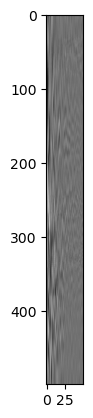

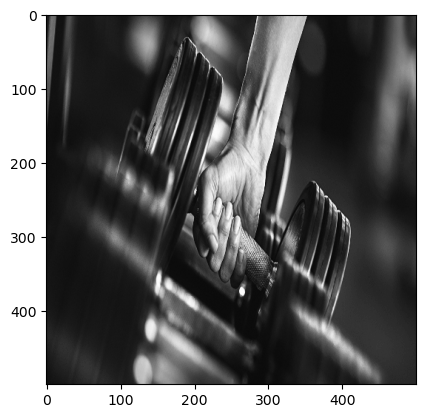

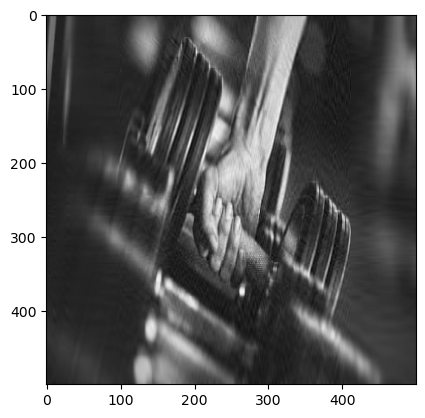

image size: 2000000, 
PCA's image size: 200000, 
reverrsed image size: 2000000


In [5]:
pca = PCA(n_components=50)
pca.fit(image)

image = np.array(image,dtype=np.float64)

pca_image= pca.transform(image)
pca_reverse = pca.reverse(pca_image) 
pca_reverse = np.real(pca_reverse)
print("pca image shape: ",pca_image.shape)

plt.imshow(pca_image,cmap="gray")
plt.show()
plt.imshow(image,cmap="gray")
plt.show()
plt.imshow(pca_reverse,cmap="gray")
plt.show()

print("image size: {}, \nPCA's image size: {}, \nreverrsed image size: {}".format(image.nbytes, pca_image.nbytes, pca_reverse.nbytes))

## PCA on RGB image

### Helper Functions

In [6]:
class RGB_PCA():
    def __init__(self,n_components):
        self.n_components = n_components
        self.pca_r = None
        self.pca_g = None
        self.pca_b = None
    
    def fit(self,image ):
        r,g,b = cv2.split(image)
        pca_r = PCA(n_components=self.n_components)
        pca_g = PCA(n_components=self.n_components)
        pca_b = PCA(n_components=self.n_components)

        pca_r.fit(r)
        pca_g.fit(g)
        pca_b.fit(b)

        self.pca_r = pca_r
        self.pca_g = pca_g
        self.pca_b = pca_b
    
    def transform(self, image):
        r,g,b = cv2.split(image)
        r = self.pca_r.transform(r)
        g = self.pca_g.transform(g)
        b = self.pca_b.transform(b)
        result = cv2.merge((r,g,b))
        return result

    def reverse(self,image):
        r,g,b = cv2.split(image)
        r = self.pca_r.reverse(r)
        g = self.pca_g.reverse(g)
        b = self.pca_b.reverse(b)
        result = cv2.merge((r,g,b))
        return result
    


In [7]:
def readimage(path):
        img =cv2.imread(path)
        img = cv2.resize(img,(400,400))
        img = cv2.cvtColor(img,cv2.COLOR_BGR2RGB)
        return img

### Code

In [8]:
image = np.array(readimage("data/test.jpg")).astype(np.float64)
image /=255.0
image.shape

(400, 400, 3)

In [9]:
pca = RGB_PCA(n_components=50)
pca.fit(image)

In [10]:

pca_imgs=pca.transform(image)
reversed_imgs = pca.reverse(pca_imgs)


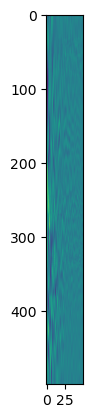

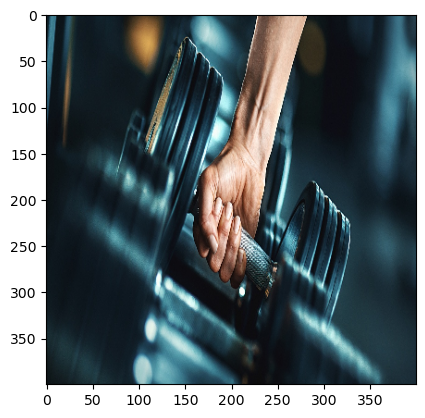

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


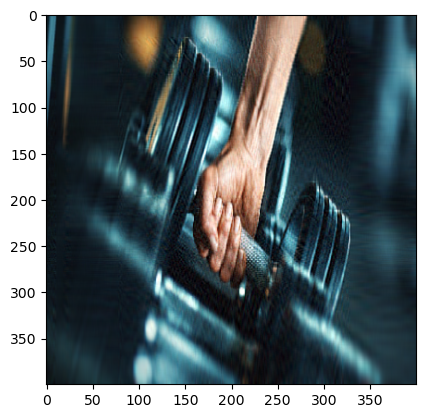

image size: 3840000, 
PCA's image size: 480000, 
reverrsed image size: 3840000


In [11]:
plt.imshow(pca_image)
plt.show()
plt.imshow(image)
plt.show()
plt.imshow(reversed_imgs)
plt.show()

print("image size: {}, \nPCA's image size: {}, \nreverrsed image size: {}".format(image.nbytes, pca_imgs.nbytes, reversed_imgs.nbytes))
# print("============================\nthe above images in different data types this is why its not has resonable sizes\n=========================")
# print("image size: {}, \nPCA's image size: {}, \nreverrsed image size: {}".format(np.array(image,dtype=np.float64).nbytes, np.array(np.real(pca_imgs),dtype=np.float64).nbytes, np.array(reversed_imgs,dtype=np.float64).nbytes))

In [139]:
def readimage(path):
        img =cv2.imread(path)
        img = cv2.resize(img,(800,800))
        img = cv2.cvtColor(img,cv2.COLOR_BGR2GRAY)
        return img

In [140]:
pathes = os.listdir(os.path.join("data","images"))
images = np.array([readimage(os.path.join("data","images",path)) for path in pathes])
shape= images.shape
images = np.array([image.reshape(-1) for image in images])


In [141]:
images= images.T
images.shape

(640000, 24)

In [146]:
pca = PCA(n_components=18)
pca.fit(images)
pca_image = pca.transform(images)
print(pca_image.shape)
reverse_image= pca.reverse(pca_image)
reverse_image = reverse_image.T
reverse_image = reverse_image.reshape(shape)

pca_image= pca_image.T
pca_image =[image.reshape(shape[1:]) for image in pca_image]

(640000, 18)


In [147]:
def plot_images(images, titles=None, rows=2, cols=5):
    
    fig, axes = plt.subplots(rows, cols, figsize=(15, 5))
    axes = axes.flatten()
    
    for i in range(rows * cols):
        if i < len(images):
            axes[i].imshow(images[i], cmap='gray')
            if titles is not None:
                axes[i].set_title(titles[i])
        else:
            axes[i].axis('off')
        axes[i].axis('off')  # Hide axes
    plt.tight_layout()
    plt.show()



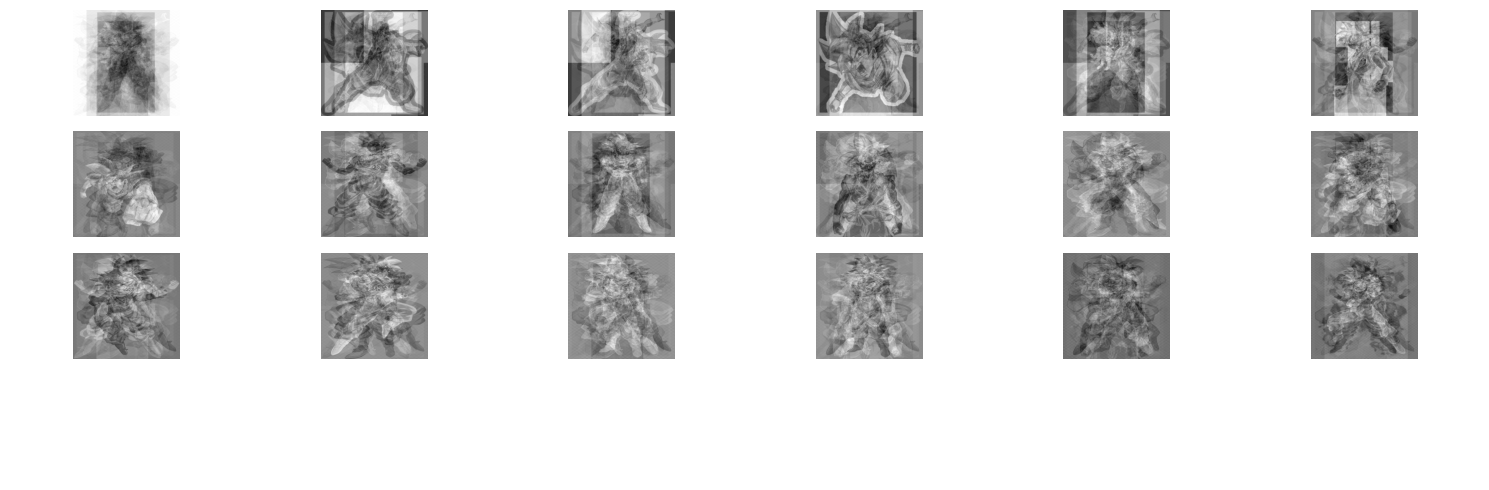

In [148]:
plot_images(pca_image, rows=4, cols=6)


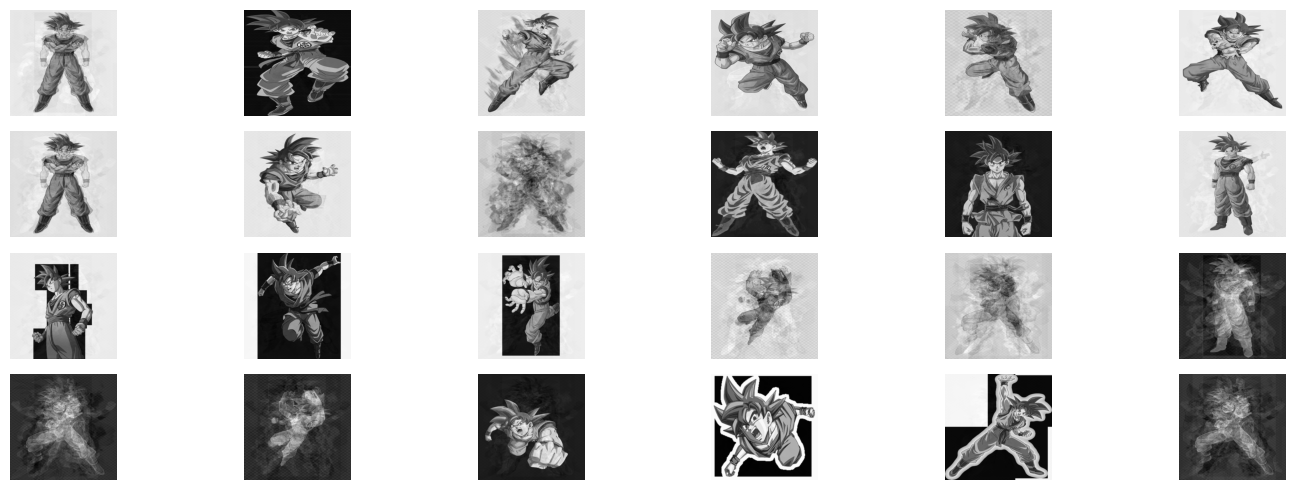

In [149]:

plot_images(reverse_image, rows=4, cols=6)